Let's create a function `render_torus` that encapsulates the ray generation, intersection testing, and coloring process. This function will take the camera position and rotation as input, making it easy to render the torus from different viewpoints.

In [1]:
!pip install trimesh[easy]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 120.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.4/128.4 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.5/728.5 kB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.0/266.0 kB 24.3 MB/s eta 0:00:00


In [2]:
import trimesh
import matplotlib.pyplot as plt
import numpy as np

# Task
Implement a 3D shape that can be viewed in 2D using ray tracing. The shape should be a green elongated rotated doughnut. The implementation should include a function that receives a ray start and angles (x, y, z, theta, psi) and returns the color using ray tracing. The implementation should be from scratch, but use libraries for ray tracing and 3D objects. The code should be organized and modular, allowing it to be easily called with different camera locations and angles. The final output should be a 3D widget. Add a light origin to the scene.

## Modify `render torus` to return intersection details

### Subtask:
Update the `render_torus` function to not just return the color, but also information about the intersection points, such as the hit location and the triangle index of the mesh that was hit.


**Reasoning**:
The subtask requires modifying the `render_torus` function to return intersection information. I will update the function definition and its return statement to include `locations`, `index_ray`, and `index_tri`. I will also update the subsequent calls to the function to handle the new return values.



## Calculate surface normals

### Subtask:
Within `render_torus`, or in a new helper function, calculate the surface normal vector at each intersection point. This can be done using the triangle index returned by the intersector.


**Reasoning**:
Define a helper function `calculate_normals_at_intersections` to get the face normals for the intersected triangles and update the `render_torus` function to call this helper and return the normals along with other intersection information.



In [3]:
def calculate_normals_at_intersections(torus_mesh, triangle_indices):
    """
    Calculates the face normal vector for each intersected triangle.

    Args:
        torus_mesh: The trimesh object of the elongated, rotated torus.
        triangle_indices: A NumPy array of triangle indices for each intersection.

    Returns:
        A NumPy array of normal vectors for each intersected triangle.
    """
    # Access the face normals using the triangle indices
    normals = torus_mesh.face_normals[triangle_indices]
    return normals

## Define light source parameters

### Subtask:
Define the direction and color of the light source.


**Reasoning**:
Define the direction and color of the light source and store them in variables.



In [4]:
# Define the light source parameters
light_direction = np.array([1, -1, -1]) # Example direction vector
light_direction = light_direction / np.linalg.norm(light_direction) # Normalize the direction vector
light_color = np.array([1.0, 1.0, 1.0]) # White light (RGB)

print("Light source direction and color defined.")

Light source direction and color defined.


## Implement a basic lighting model

### Subtask:
Create a function that calculates the color at an intersection point based on the object's color, the light source direction and color, and the surface normal at the intersection point. A simple diffuse lighting model (Lambertian reflection) is a good starting point.


**Reasoning**:
Define a function `apply_lighting` that calculates the shaded color at an intersection point using a simple diffuse lighting model based on the point color, surface normal, light direction, and light color.



In [5]:
def apply_lighting(point_color, surface_normal, light_direction, light_color):
    """
    Applies a simple diffuse lighting model (Lambertian reflection) to calculate
    the shaded color at an intersection point.

    Args:
        point_color: The base color of the object at the point (NumPy array or list).
        surface_normal: The normal vector at the intersection point (NumPy array).
        light_direction: The normalized direction vector to the light source (NumPy array).
        light_color: The color of the light source (NumPy array or list).

    Returns:
        A NumPy array representing the calculated shaded color.
    """
    # Ensure inputs are numpy arrays for calculations
    point_color = np.array(point_color)
    surface_normal = np.array(surface_normal)
    light_direction = np.array(light_direction)
    light_color = np.array(light_color)

    # Normalize the surface normal and light direction (should already be normalized, but good practice)
    surface_normal = surface_normal / np.linalg.norm(surface_normal)
    light_direction = light_direction / np.linalg.norm(light_direction)

    # Calculate the diffuse light intensity using the dot product
    # Ensure the dot product is not negative (light hitting the back of the surface)
    diffuse_intensity = max(0, np.dot(surface_normal, light_direction))

    # Calculate the shaded color
    shaded_color = point_color * diffuse_intensity * light_color

    # Clamp the color values to be between 0 and 1
    shaded_color = np.clip(shaded_color, 0, 1)

    return shaded_color

print("apply_lighting function defined.")

apply_lighting function defined.


## Apply lighting in `render torus`

### Subtask:
Modify the loop in `render_torus` that processes intersections to call the lighting model function for each hit point and use the returned shaded color instead of just the fixed doughnut color.


**Reasoning**:
Modify the `render_torus` function to incorporate the lighting model by calling `apply_lighting` for each intersected pixel, using the calculated normal vector, light direction, and light color to determine the final shaded color of the pixel.



In [6]:
def get_views_coords_rays(camera_position,
    camera_rotation_angles, # Euler angles (theta_x, theta_y, theta_z)
    view_plane_width,
    view_plane_height,
    plane_distance):
    # Create a grid of points on the view plane in camera space
    x_coords = np.linspace(-view_plane_width / 2, view_plane_width / 2, image_width)
    y_coords = np.linspace(-view_plane_height / 2, view_plane_height / 2, image_height)
    xv, yv = np.meshgrid(x_coords, y_coords)
    view_plane_points_camera_space = np.vstack((xv.flatten(), yv.flatten(), np.full(xv.size, plane_distance))).T

    # Apply the inverse camera rotation to the view plane points to get them in world space relative to the camera position
    # First, create the camera's rotation matrix from Euler angles
    camera_rotation_matrix = R_scipy.from_euler('xyz', camera_rotation_angles).as_matrix()
    # Apply the inverse rotation to the view plane points (which are currently in camera's local space)
    # The view plane points in world space, relative to the camera's origin
    view_plane_points_rotated = (camera_rotation_matrix @ view_plane_points_camera_space.T).T

    # Calculate ray directions from the camera position to each point on the rotated view plane
    # Ray direction is point_on_plane_in_world - camera_position
    # Since view_plane_points_rotated are relative to the camera's origin in world space,
    # the ray direction from camera_position is simply these rotated points.
    # However, the ray origin is camera_position, and direction is a vector from camera_position
    # to the point on the view plane in world space.
    # The points on the view plane in world space are camera_position + view_plane_points_rotated
    ray_origins = np.tile(np.array(camera_position), (image_width * image_height, 1))
    points_on_plane_world = ray_origins + view_plane_points_rotated

    # Ray direction vectors are from camera_position to points_on_plane_world
    ray_directions = points_on_plane_world - ray_origins

    # Normalize the direction vectors
    ray_directions = ray_directions / np.linalg.norm(ray_directions, axis=1)[:, np.newaxis]
    return ray_origins, ray_directions

In [7]:
def render_torus(
    torus_mesh,
    camera_position,
    camera_rotation_angles, # Euler angles (theta_x, theta_y, theta_z)
    view_plane_width,
    view_plane_height,
    plane_distance,
    image_width,
    image_height,
    doughnut_color,
    background_color,
    light_direction,
    light_color
):
    """
    Renders the elongated, rotated torus from a given camera position and rotation
    with basic lighting.

    Args:
        torus_mesh: The trimesh object of the elongated, rotated torus.
        camera_position: A tuple or list (x, y, z) for the camera's position.
        camera_rotation_angles: A tuple or list (theta_x, theta_y, theta_z) for rotation around x, y, and z axes in radians.
        view_plane_width: The width of the view plane.
        view_plane_height: The height of the view plane.
        plane_distance: The distance from the camera to the view plane.
        image_width: The width of the output image in pixels.
        image_height: The height of the output image in pixels.
        doughnut_color: A tuple (R, G, B) for the base color of the torus.
        background_color: A tuple (R, G, B) for the background color.
        light_direction: The normalized direction vector to the light source (NumPy array).
        light_color: The color of the light source (NumPy array or list).


    Returns:
        A tuple containing:
        - A NumPy array representing the rendered image.
        - A NumPy array of intersection locations.
        - A NumPy array of ray indices for each intersection.
        - A NumPy array of triangle indices for each intersection.
        - A NumPy array of normal vectors at each intersection.
    """
    # Create a RayMeshIntersector object from the torus mesh
    # Rely on trimesh to choose the best available intersector (pyembree or built-in)
    try:
        intersector = trimesh.ray.ray_pyembree.RayMeshIntersector(torus_mesh)
    except Exception as e:
        print(f"Pyembree not available or initialization failed: {e}")
        print("Falling back to built-in ray tester (slower).")
        # If pyembree fails, trimesh.ray.RayMeshIntersector should fall back to a slower
        # but functional implementation if pyembree is the only accelerated option.
        # We remove the explicit call to ray_accelerated as it may not exist.
        intersector = trimesh.ray.ray_accelerated.RayMeshIntersector(torus_mesh)


    ray_origins, ray_directions = get_views_coords_rays(camera_position,
                                                        camera_rotation_angles, # Euler angles (theta_x, theta_y, theta_z)
                                                        view_plane_width,
                                                        view_plane_height,
                                                        plane_distance)

    # Find intersections using the intersector
    locations, index_ray, index_tri = intersector.intersects_location(
        ray_origins=ray_origins,
        ray_directions=ray_directions
    )

    # Calculate normals at the intersection points
    normals = calculate_normals_at_intersections(torus_mesh, index_tri)


    # Create the rendered image array
    rendered_image_colors = np.full((image_height, image_width, 3), background_color)

    # Populate the image array with torus color for intersections
    # We need to find the closest intersection for each ray
    closest_intersections = {}
    for i in range(len(index_ray)):
        ray_idx = index_ray[i]
        hit_location = locations[i]
        hit_normal = normals[i]

        # Calculate the distance from the camera to this intersection point
        distance = np.linalg.norm(hit_location - np.array(camera_position))

        # Check if this ray index is already in the dictionary, and if this hit is closer
        if ray_idx not in closest_intersections or distance < closest_intersections[ray_idx]['distance']:
            closest_intersections[ray_idx] = {'location': hit_location, 'distance': distance, 'normal': hit_normal}

    # Set the color for the intersected pixels
    for ray_idx, data in closest_intersections.items():
        # Calculate the pixel coordinates (need to map the flattened ray index back to 2D)
        row = ray_idx // image_width
        col = ray_idx % image_width

        # Apply lighting to get the shaded color
        shaded_color = apply_lighting(data['location'], data['normal'], light_direction, light_color)

        # Set the color for the intersected pixel using the shaded color
        rendered_image_colors[row, col, :] = shaded_color

    return rendered_image_colors, locations, index_ray, index_tri, normals

## Render and visualize

### Subtask:
Render and visualize the torus with lighting applied using the updated `render_torus` function.


**Reasoning**:
Render and visualize the torus with lighting applied using the updated `render_torus` function.



In [8]:
# Define parameters for the elongated rotated torus
R = 2.0  # Major radius
r = 0.5  # Minor radius
elongation_factor = 5.0  # Elongation along the y-axis in the object's local frame before rotation
rotation_angles_torus = (np.pi/4, np.pi/6, np.pi/8)  # Rotation of the torus around x, y, z axes

# Create a basic torus mesh
torus_mesh = trimesh.creation.torus(major_radius=R, minor_radius=r)

# Apply elongation
elongation_transform = trimesh.transformations.scale_matrix(elongation_factor, origin=[0,0,0], direction=[0,1,0])
torus_mesh.apply_transform(elongation_transform)

# Apply rotation to the torus
from scipy.spatial.transform import Rotation as R_scipy
rotation_matrix_torus = R_scipy.from_euler('xyz', rotation_angles_torus).as_matrix()
rotation_transform_torus = trimesh.transformations.translation_matrix([0,0,0])
rotation_transform_torus[:3, :3] = rotation_matrix_torus
torus_mesh.apply_transform(rotation_transform_torus)

print("Elongated and rotated torus mesh created.")

# Define rendering parameters
view_plane_width = 10
view_plane_height = 10
plane_distance = 5
image_width = 200
image_height = 200
doughnut_color = (0.1, 0.8, 0.2)
background_color = [1.0]*3

# Define camera parameters
camera_position = [0, 0, -10]
camera_rotation_angles = (0, 0, 0) # No camera rotation initially

# Example of rendering from a different camera angle
camera_position_angled = [5, 5, -10]
camera_rotation_angles_angled = (np.pi/6, -np.pi/4, 0) # Rotate camera

Elongated and rotated torus mesh created.


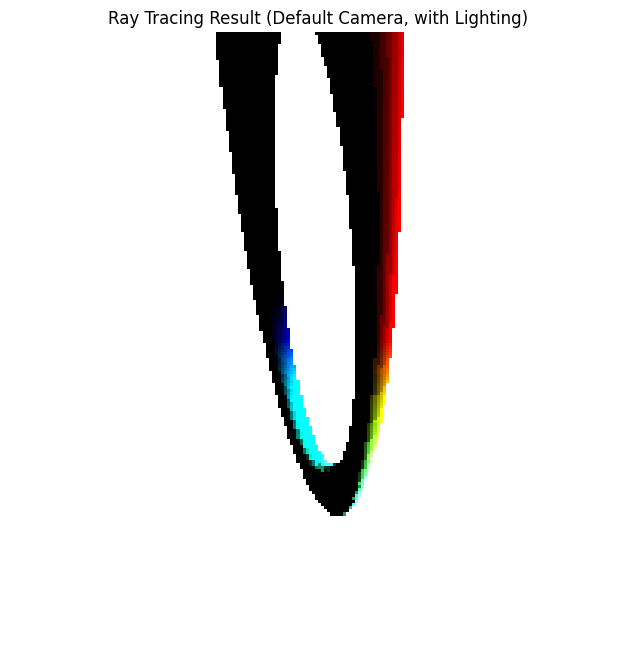

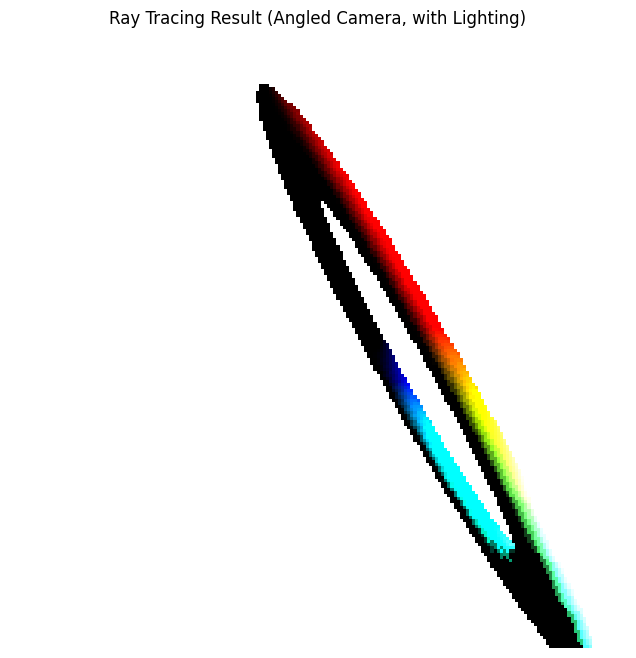

In [9]:
# Render the torus with lighting
rendered_image_lit = render_torus(
    torus_mesh,
    camera_position,
    camera_rotation_angles,
    view_plane_width,
    view_plane_height,
    plane_distance,
    image_width,
    image_height,
    doughnut_color,
    background_color,
    light_direction,
    light_color
)

# Visualize the result
plt.figure(figsize=(8, 8))
plt.imshow(rendered_image_lit[0]) # Use the first element of the returned tuple (the image array)
plt.title("Ray Tracing Result (Default Camera, with Lighting)")
plt.axis('off')
plt.show()



# Render the torus from a different camera angle with lighting
rendered_image_angled_lit = render_torus(
    torus_mesh,
    camera_position_angled,
    camera_rotation_angles_angled,
    view_plane_width,
    view_plane_height,
    plane_distance,
    image_width,
    image_height,
    doughnut_color,
    background_color,
    light_direction,
    light_color
)

# Visualize the result
plt.figure(figsize=(8, 8))
plt.imshow(rendered_image_angled_lit[0]) # Use the first element of the returned tuple (the image array)
plt.title("Ray Tracing Result (Angled Camera, with Lighting)")
plt.axis('off')
plt.show()

## Summary:

### Data Analysis Key Findings

*   The `render_torus` function was successfully modified to return intersection details (locations, ray indices, and triangle indices) obtained from the `trimesh.ray.ray_pyembree.RayMeshIntersector.intersects_location()` method.
*   A helper function `calculate_normals_at_intersections` was created to compute face normals at the intersection points using the provided triangle indices, and this functionality was integrated into `render_torus`.
*   Light source parameters, including a normalized direction vector and color, were defined.
*   A basic diffuse lighting model (`apply_lighting` function) based on Lambertian reflection was implemented to calculate shaded colors using object color, surface normal, light direction, and light color.
*   The `render_torus` function was further updated to call `apply_lighting` for each intersected pixel, using the calculated shaded color instead of a fixed object color.
*   The torus was successfully rendered and visualized with the applied lighting from both a default camera position and an angled camera position, demonstrating the effect of the diffuse lighting model.

### Insights or Next Steps

*   Implement additional lighting models (e.g., ambient, specular) to enhance the realism of the rendering.
*   Consider adding shadow calculations to further improve the lighting effect.


# Task
Add the projection of the xyz axes unto the 2d imshow.

## Define the 3d axes

### Subtask:
Define the endpoints of the X, Y, and Z axes in 3D world coordinates.


**Reasoning**:
Define the origin and endpoints of the X, Y, and Z axes in 3D world coordinates using NumPy arrays.



In [10]:
# Define the origin of the axes
axis_origin = np.array([0, 0, 0])

# Define the endpoints of the X, Y, and Z axes
axis_length = 5
x_axis_endpoint = np.array([axis_length, 0, 0])
y_axis_endpoint = np.array([0, axis_length, 0])
z_axis_endpoint = np.array([0, 0, axis_length])

print("Axis origin and endpoints defined.")

Axis origin and endpoints defined.


## Project the axis endpoints to 2d

### Subtask:
Implement a function or add code within the rendering process to project the 3D endpoints of the axes onto the 2D view plane, taking into account the camera's position and rotation, and the view plane parameters. This will involve similar transformations used for ray generation.


**Reasoning**:
Implement the `project_3d_to_2d` function as described in the instructions.



In [11]:
def project_3d_to_2d(
    point_3d,
    camera_position,
    camera_rotation_angles,
    view_plane_width,
    view_plane_height,
    plane_distance,
    image_width,
    image_height,
):
    """
    Projects a 3D point in world space onto the 2D view plane in pixel coordinates.

    Args:
        point_3d: A NumPy array or list (x, y, z) of the 3D point in world space.
        camera_position: A tuple or list (x, y, z) for the camera's position.
        camera_rotation_angles: A tuple or list (theta_x, theta_y, theta_z) for rotation around x, y, and z axes in radians.
        view_plane_width: The width of the view plane.
        view_plane_height: The height of the view plane.
        plane_distance: The distance from the camera to the view plane.
        image_width: The width of the output image in pixels.
        image_height: The height of the output image in pixels.

    Returns:
        A tuple (x_pixel, y_pixel) representing the pixel coordinates on the image.
        Returns None if the projected point is behind the camera.
    """
    point_3d = np.array(point_3d)
    camera_position = np.array(camera_position)

    # 1. Translate the 3D point to camera space
    point_camera_space = point_3d - camera_position

    # 2. Apply the inverse camera rotation to the point in camera space
    # Camera rotation matrix transforms from camera space to world space.
    # We need the inverse to go from world space (relative to camera origin) to camera space.
    camera_rotation_matrix = R_scipy.from_euler('xyz', camera_rotation_angles).as_matrix()
    inverse_camera_rotation_matrix = np.linalg.inv(camera_rotation_matrix)
    point_camera_space_rotated = (inverse_camera_rotation_matrix @ point_camera_space.T).T


    # Check if the point is behind the camera (z < plane_distance in camera space)
    # Using a small epsilon to handle potential floating point issues
    if point_camera_space_rotated[2] < plane_distance - 1e-6:
         return None # Point is behind the camera or on the view plane

    # 3. Project the rotated point onto the view plane
    # Use similar triangles: x_projected / plane_distance = x_camera_space_rotated / z_camera_space_rotated
    # So, x_projected = (x_camera_space_rotated / z_camera_space_rotated) * plane_distance
    x_projected = (point_camera_space_rotated[0] / point_camera_space_rotated[2]) * plane_distance
    y_projected = (point_camera_space_rotated[1] / point_camera_space_rotated[2]) * plane_distance

    # 4. Convert the projected point on the view plane to pixel coordinates
    # Map from view plane coordinates (-view_plane_width/2 to view_plane_width/2)
    # to pixel coordinates (0 to image_width)
    x_pixel = int(((x_projected + view_plane_width / 2) / view_plane_width) * image_width)
    y_pixel = int(((y_projected + view_plane_height / 2) / view_plane_height) * image_height)

    # Invert the y-axis since image coordinates typically have (0,0) at the top-left
    y_pixel = image_height - 1 - y_pixel


    return x_pixel, y_pixel

print("project_3d_to_2d function defined.")

project_3d_to_2d function defined.


## Convert projected points to pixel coordinates

### Subtask:
Map the projected 2D points on the view plane to pixel coordinates of the output image.


**Reasoning**:
Map the projected 2D points on the view plane to pixel coordinates of the output image by calling the `project_3d_to_2d` function for the axis origin and endpoints and storing the resulting pixel coordinates.



In [12]:
def get_projected_axis_pixels(
    camera_position,
    camera_rotation_angles,
    view_plane_width,
    view_plane_height,
    plane_distance,
    image_width,
    image_height,
    axis_length=5 # Define axis_length as a parameter with a default value
):
    """
    Projects the 3D XYZ axis endpoints to 2D pixel coordinates on the view plane.

    Args:
        camera_position: A tuple or list (x, y, z) for the camera's position.
        camera_rotation_angles: A tuple or list (theta_x, theta_y, theta_z) for rotation around x, y, and z axes in radians.
        view_plane_width: The width of the view plane.
        view_plane_height: The height of the view plane.
        plane_distance: The distance from the camera to the view plane.
        image_width: The width of the output image in pixels.
        image_height: The height of the output image in pixels.
        axis_length: The length of the axes in 3D world units.

    Returns:
        A tuple containing the pixel coordinates of the axis origin,
        and the pixel coordinates of the X, Y, and Z axis endpoints.
        Each coordinate will be None if the point is behind the camera.
        (origin_pixel, x_axis_pixel, y_axis_pixel, z_axis_pixel)
    """
    # Define the origin of the axes
    axis_origin = np.array([0, 0, 0])

    # Define the endpoints of the X, Y, and Z axes
    x_axis_endpoint = np.array([axis_length, 0, 0])
    y_axis_endpoint = np.array([0, axis_length, 0])
    z_axis_endpoint = np.array([0, 0, axis_length])

    # Project the axis origin and endpoints to 2D pixel coordinates
    origin_pixel = project_3d_to_2d(
        axis_origin,
        camera_position,
        camera_rotation_angles,
        view_plane_width,
        view_plane_height,
        plane_distance,
        image_width,
        image_height,
    )

    x_axis_pixel = project_3d_to_2d(
        x_axis_endpoint,
        camera_position,
        camera_rotation_angles,
        view_plane_width,
        view_plane_height,
        plane_distance,
        image_width,
        image_height,
    )

    y_axis_pixel = project_3d_to_2d(
        y_axis_endpoint,
        camera_position,
        camera_rotation_angles,
        view_plane_width,
        view_plane_height,
        plane_distance,
        image_width,
        image_height,
    )

    z_axis_pixel = project_3d_to_2d(
        z_axis_endpoint,
        camera_position,
        camera_rotation_angles,
        view_plane_width,
        view_plane_height,
        plane_distance,
        image_width,
        image_height,
    )

    return origin_pixel, x_axis_pixel, y_axis_pixel, z_axis_pixel

## Draw the projected axes on the image

### Subtask:
Use a drawing library (like OpenCV or Pillow, or potentially Matplotlib's drawing functions) to draw lines on the rendered image connecting the projected endpoints of each axis.


**Reasoning**:
Draw the projected axes on the rendered image using matplotlib's drawing functions, ensuring the origin and endpoints are not None and using different colors for each axis.



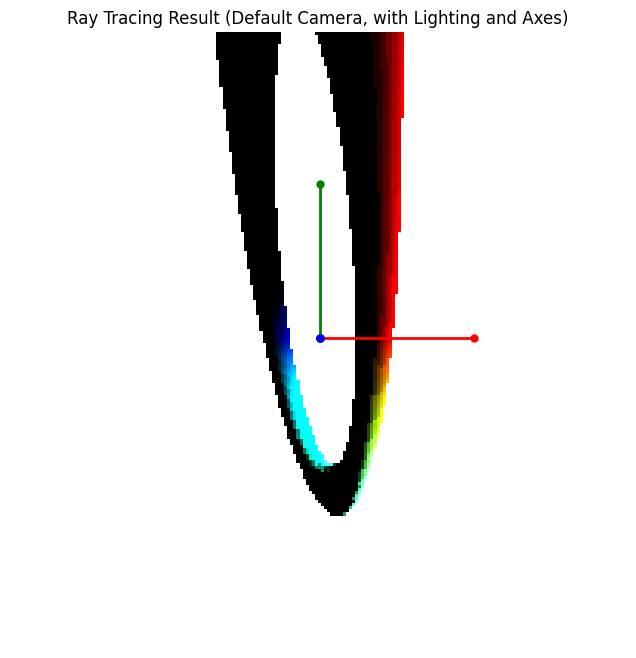

In [13]:
# Render the torus with lighting
rendered_image_lit, locations, index_ray, index_tri, normals = render_torus(
    torus_mesh,
    camera_position,
    camera_rotation_angles,
    view_plane_width,
    view_plane_height,
    plane_distance,
    image_width,
    image_height,
    doughnut_color,
    background_color,
    light_direction,
    light_color
)

# Get projected axis pixel coordinates
origin_pixel, x_axis_pixel, y_axis_pixel, z_axis_pixel = get_projected_axis_pixels(
    camera_position,
    camera_rotation_angles,
    view_plane_width,
    view_plane_height,
    plane_distance,
    image_width,
    image_height
)


# Visualize the result
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(rendered_image_lit)
ax.set_title("Ray Tracing Result (Default Camera, with Lighting and Axes)")
ax.axis('off')

# Draw the projected axes on the image
# Check if origin and endpoint are visible before drawing
if origin_pixel is not None:
    if x_axis_pixel is not None:
        ax.plot([origin_pixel[0], x_axis_pixel[0]], [origin_pixel[1], x_axis_pixel[1]], color='red', marker='o', markersize=5, linewidth=2)
    if y_axis_pixel is not None:
        ax.plot([origin_pixel[0], y_axis_pixel[0]], [origin_pixel[1], y_axis_pixel[1]], color='green', marker='o', markersize=5, linewidth=2)
    if z_axis_pixel is not None:
        ax.plot([origin_pixel[0], z_axis_pixel[0]], [origin_pixel[1], z_axis_pixel[1]], color='blue', marker='o', markersize=5, linewidth=2)

plt.show()

## Visualize the result

### Subtask:
Display the modified rendered image with the projected axes using Matplotlib.


**Reasoning**:
Display the plot containing the rendered image with the projected axes using Matplotlib.



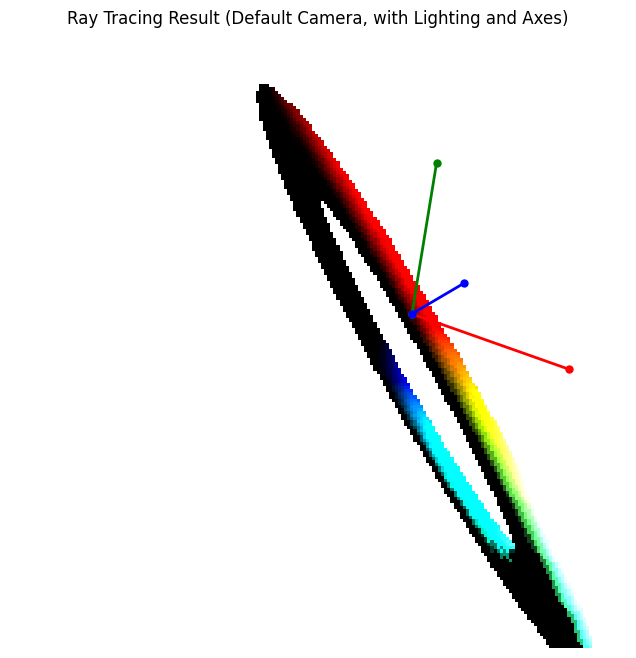

In [14]:
# Render the torus with lighting
rendered_image_lit, locations, index_ray, index_tri, normals = render_torus(
    torus_mesh,
    camera_position_angled,
    camera_rotation_angles_angled,
    view_plane_width,
    view_plane_height,
    plane_distance,
    image_width,
    image_height,
    doughnut_color,
    background_color,
    light_direction,
    light_color
)

# Get projected axis pixel coordinates
origin_pixel, x_axis_pixel, y_axis_pixel, z_axis_pixel = get_projected_axis_pixels(
    camera_position_angled,
    camera_rotation_angles_angled,
    view_plane_width,
    view_plane_height,
    plane_distance,
    image_width,
    image_height
)


# Visualize the result
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(rendered_image_lit)
ax.set_title("Ray Tracing Result (Default Camera, with Lighting and Axes)")
ax.axis('off')

# Draw the projected axes on the image
# Check if origin and endpoint are visible before drawing
if origin_pixel is not None:
    if x_axis_pixel is not None:
        ax.plot([origin_pixel[0], x_axis_pixel[0]], [origin_pixel[1], x_axis_pixel[1]], color='red', marker='o', markersize=5, linewidth=2)
    if y_axis_pixel is not None:
        ax.plot([origin_pixel[0], y_axis_pixel[0]], [origin_pixel[1], y_axis_pixel[1]], color='green', marker='o', markersize=5, linewidth=2)
    if z_axis_pixel is not None:
        ax.plot([origin_pixel[0], z_axis_pixel[0]], [origin_pixel[1], z_axis_pixel[1]], color='blue', marker='o', markersize=5, linewidth=2)

plt.show()

# Sample views

In [15]:
N_VIEWS = 10

In [16]:
import random
from scipy.spatial.transform import Rotation as R_scipy

def view_generator(
    torus_mesh,
    view_plane_width,
    view_plane_height,
    plane_distance,
    image_width,
    image_height,
    doughnut_color,
    background_color,
    light_direction,
    light_color,
    s_loc=2.0,  # Standard deviation for camera location sampling
    s_theta=np.pi/16,  # Standard deviation for camera angle sampling (in radians)
    min_distance=1.0, # Minimum distance from origin
    seed=0
):
    """
    Generates rendered images of the torus from different sampled camera views.

    Args:
        torus_mesh: The trimesh object of the elongated, rotated torus.
        view_plane_width: The width of the view plane.
        view_plane_height: The height of the view plane.
        plane_distance: The distance from the camera to the view plane.
        image_width: The width of the output image in pixels.
        image_height: The height of the output image in pixels.
        doughnut_color: A tuple (R, G, B) for the base color of the torus.
        background_color: A tuple (R, G, B) for the background color.
        light_direction: The normalized direction vector to the light source (NumPy array).
        light_color: The color of the light source (NumPy array or list).
        num_views: The number of views to generate.
        s_loc: Standard deviation for camera location sampling (around (0,0,0)).
        s_theta: Standard deviation for camera angle sampling (in radians, around direction to origin).
        min_distance: Minimum distance from the origin for the camera position.

    Yields:
        A NumPy array representing the rendered image for each sampled view.
    """
    if seed:
      np.random.seed(seed)
    # Sample camera location
    while True:
      while True:
          camera_position = np.random.normal([0, 0, 0], s_loc, 3)
          if np.linalg.norm(camera_position) >= min_distance:
              break

      # Calculate the vector from camera position to the origin
      vec_to_origin = np.array([0, 0, 0]) - np.array(camera_position)
      vec_to_origin_normalized = vec_to_origin / np.linalg.norm(vec_to_origin)

      # Calculate the rotation to point the camera's positive Z-axis towards the origin
      # In our ray tracing setup, rays are cast along the positive Z-axis in camera space,
      # which then gets transformed to world space. So we want the camera's positive Z-axis
      # in world space to align with vec_to_origin_normalized.

      # We can use scipy.spatial.transform.Rotation.align_vectors to find the rotation
      # that aligns the camera's initial positive Z-axis (e.g., [0,0,1]) with vec_to_origin_normalized.
      initial_z_axis = np.array([0, 0, 1])
      rotation, _ = R_scipy.align_vectors([vec_to_origin_normalized], [initial_z_axis])

      # Get the base Euler angles from this rotation
      base_euler_angles = rotation.as_euler('xyz')

      # Add Gaussian noise to these base angles
      noisy_euler_angles = base_euler_angles + np.random.normal([0, 0, 0], s_theta, 3)
      camera_rotation_angles = tuple(noisy_euler_angles)


      # Render the torus from this sampled view
      rendered_image, _, _, _, _ = render_torus(
          torus_mesh,
          camera_position,
          camera_rotation_angles,
          view_plane_width,
          view_plane_height,
          plane_distance,
          image_width,
          image_height,
          doughnut_color,
          background_color,
          light_direction,
          light_color
      )

      yield camera_position, camera_rotation_angles[:-1], rendered_image

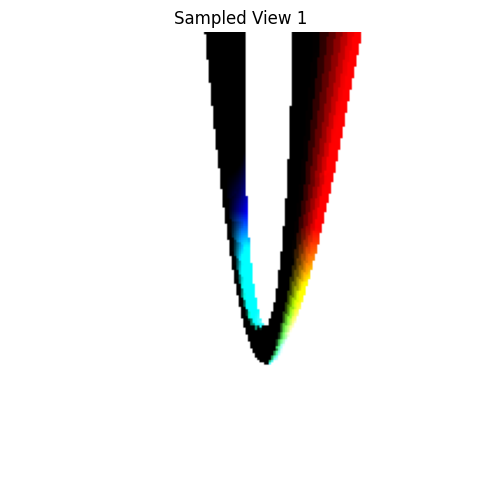

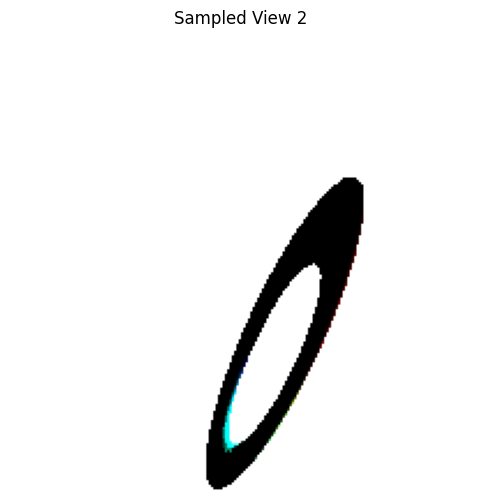

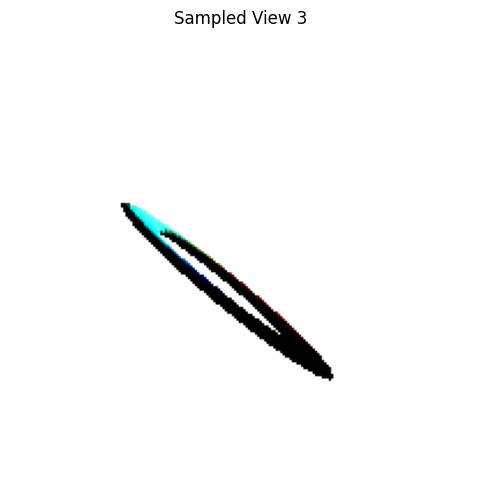

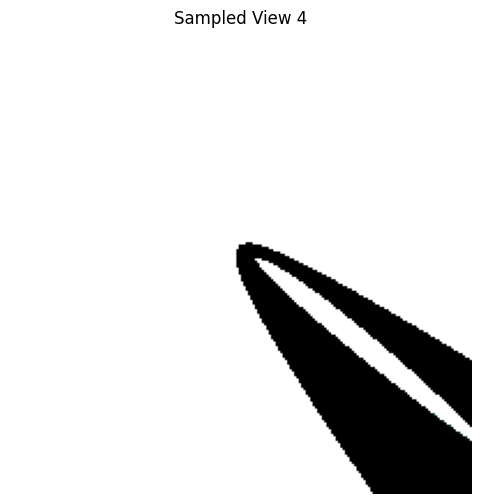

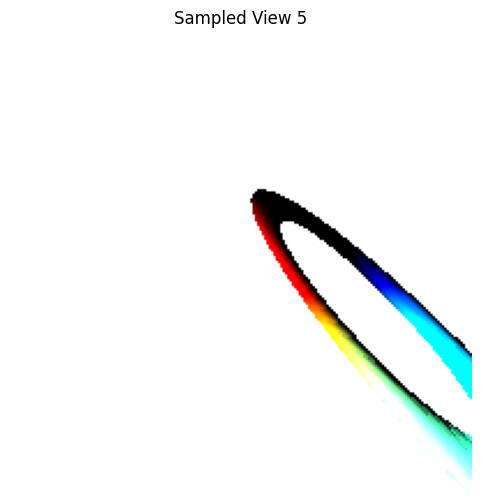

In [17]:
# Example of using the view generator

# Create and use the generator
view_gen = view_generator(
    torus_mesh,
    view_plane_width,
    view_plane_height,
    plane_distance,
    image_width,
    image_height,
    doughnut_color,
    background_color,
    light_direction,
    light_color,
    s_loc=8.0, # Increase spatial variance for more diverse locations
    s_theta=np.pi/16 # Increase angular variance
)

# Display the generated views
for i in range(5):
  _0, _1, rendered_view = next(view_gen)
  plt.figure(figsize=(6, 6))
  plt.imshow(rendered_view)
  plt.title(f"Sampled View {i+1}")
  plt.axis('off')
  plt.show()

# NeRF

## Get Dataset

In [18]:
train_gen = view_gen = view_generator(
    torus_mesh,
    view_plane_width,
    view_plane_height,
    plane_distance,
    image_width,
    image_height,
    doughnut_color,
    background_color,
    light_direction,
    light_color,
    s_loc=8.0, # Increase spatial variance for more diverse locations
    s_theta=np.pi/16 # Increase angular variance
)

num_train_views = 50
train_images = []
train_positions = []
train_angles = []
for i in range(num_train_views):
  camera_position, camera_rotation_angles, rendered_view = next(train_gen)
  train_images.append(rendered_view)
  train_positions.append(camera_position)
  train_angles.append(camera_rotation_angles)

In [19]:
test_gen = view_gen = view_generator(
    torus_mesh,
    view_plane_width,
    view_plane_height,
    plane_distance,
    image_width,
    image_height,
    doughnut_color,
    background_color,
    light_direction,
    light_color,
    s_loc=8.0, # Increase spatial variance for more diverse locations
    s_theta=np.pi/16 # Increase angular variance
)

num_test_views = 50
test_images = []
test_positions = []
test_angles = []
for i in range(num_test_views):
  camera_position, camera_rotation_angles, rendered_view = next(test_gen)
  test_images.append(rendered_view)
  test_positions.append(camera_position)
  test_angles.append(camera_rotation_angles)

# Functions

In [20]:
import tensorflow as tf

class SimpleMLP(tf.keras.Model):
    def __init__(self, num_inputs, num_outputs, depth, width, activation='relu', out_activation=None):
        super(SimpleMLP, self).__init__(name='nerf')
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.depth = depth
        self.width = width
        # self.inp = tf.keras.layers.Input(shape=(num_inputs,), name='input')

        # Input layer
        self.dense_layers = []

        # Hidden layers
        for i in range(depth):
            self.dense_layers.append(tf.keras.layers.Dense(width, activation=activation, name=f'dense{i}'))

        # Output layer
        self.dense_layers.append(tf.keras.layers.Dense(num_outputs, activation=out_activation, name='out'))

    def call(self, inputs):
        # x = self.inp(inputs)
        x = inputs
        for layer in self.dense_layers:
            x = layer(x)
        return x

In [21]:
dtype = tf.float32

def position_encoding_func(x, L=10):
  # x.shape = (B, M)
  return tf.reshape(tf.stack([tf.sin(2**tf.cast(tf.range(L), dtype=dtype)[None, None] * np.pi * x[..., None]),
                   tf.cos(2**tf.cast(tf.range(L), dtype=dtype)[None, None] * np.pi * x[..., None])], axis=-1), [-1, x.shape[1]*2*L])


def position_encoding(camera_position, camera_rotation_angle, Lx=10, Ld=4):
  x = position_encoding_func(camera_position, Lx)
  mult = camera_rotation_angle[..., 0]*camera_rotation_angle[..., 1]
  angle_to_vec = tf.stack([tf.sin(mult)*tf.cos(mult), tf.sin(mult)*tf.sin(mult), tf.cos(camera_rotation_angle[..., 1])], axis=-1)
  d = position_encoding_func(angle_to_vec, Ld)
  # print(x.shape, mult.shape, angle_to_vec.shape, d.shape)
  return tf.concat([x, d], axis=-1)

In [22]:
def render_from_nerf(nerf, camera_position, camera_rotation_angles, delta=1e-1, distance=32,
                     image_height=image_height, image_width=image_width, view_plane_width=view_plane_width,
                                                      view_plane_height=view_plane_height,
                     Ld=4, Lx=10,
                     batch_chunks=256,
                     mask=None):
  ray_origins, ray_directions = get_views_coords_rays(camera_position,
                                                      list(camera_rotation_angles) + [0], # Euler angles (theta_x, theta_y, theta_z)
                                                      view_plane_width,
                                                      view_plane_height,
                                                      plane_distance)
  ray_origins = tf.convert_to_tensor(ray_origins, dtype=tf.float32) # (B, 3)
  ray_directions = tf.convert_to_tensor(ray_directions, dtype=tf.float32) # (B, 3)
  dists = tf.range(0, distance, delta)[None]
  B = ray_origins.shape[0]
  D = dists.shape[1] - 1

  full_colors = []
  if batch_chunks==1:
    raise NotImplementedError()
    # for i in np.where(mask)[0] if mask is not None else range(B):
    #   cur_ray_origins = tf.expand_dims(ray_origins[i], axis=0)  # (1, 3)
    #   cur_ray_directions = tf.expand_dims(ray_directions[i], axis=0)  # (1, 3)
    #   coords = cur_ray_origins + cur_ray_directions * dists[:, None]  # (D, 3)
    #   repeated_direction = tf.repeat(cur_ray_directions, dists.shape[0], axis=0) # (D, 3)
    #   coords_and_angle = tf.concat([coords, repeated_direction], axis=-1) # (D, 5)
    #   # print(coords_and_angle)
    #   colors = nerf(coords_and_angle) # (D, 4)
    #   integrated_alpha = tf.exp(-tf.math.cumsum(colors[..., -1], axis=0)) # (D)
    #   # print(integrated_alpha)
    #   integrated_colors = tf.einsum('dc,d,d->c', colors[..., :-1], integrated_alpha, colors[..., -1]) # (C)
    #   full_colors.append(integrated_colors)
    # full_colors = tf.stack(full_colors, axis=0) # (M, C)
    # return full_colors
  else:
    inds = np.arange(B) if mask is None else np.where(mask)[0]
    if not batch_chunks:
      batch_chunks = inds.size
    indices_splitted_to_chunks = np.array_split(inds, np.ceil(len(inds)/batch_chunks))
    full_colors = []
    for chunk in indices_splitted_to_chunks:
      cur_dists = dists + tf.random.uniform((chunk.shape[0], D+1))*delta

      cur_orig = tf.gather(ray_origins, chunk, axis=0)
      cur_direc = tf.gather(ray_directions, chunk, axis=0)
      coords = cur_orig[:, None] + cur_direc[:, None] * cur_dists[:, :-1, None]  # (B, D, 3)
      coords = tf.reshape(coords, [-1, 3])  # (B*D, 3)
      repeated_direction = tf.repeat(cur_direc, D, axis=0) # (B*D, 3)
      coords_and_angle = tf.concat([coords, repeated_direction], axis=-1) # (B*D, 5)

      position_encoding(coords_and_angle[..., :3], coords_and_angle[..., 3:], Lx=Lx, Ld=Ld)

      colors = nerf(coords_and_angle) # (B*D, 4)
      colors = tf.reshape(colors, [-1, D, 4]) # (B, D, 4)
      # print(f"{colors.shape=}")

      # integrate
      alpha = tf.nn.relu(colors[..., -1])
      d_diff = tf.keras.ops.diff(cur_dists, axis=-1)
      cols = tf.nn.sigmoid(colors[..., :-1])
      integrated_alpha = tf.exp(-tf.math.cumsum(alpha*tf.concat([tf.zeros_like(d_diff[:,:1]), d_diff[:, :-1]], axis=1), axis=-1)) # (B, D)
      integrated_colors = tf.einsum('bdc,bd,bd->bc', cols, integrated_alpha, 1.-tf.exp(-alpha*d_diff)) # (B, C)
      # print(f"{integrated_alpha.shape=}")
      # print(f"{integrated_colors.shape=}")
      full_colors.append(integrated_colors)
    return tf.concat(full_colors, axis=0)

In [23]:
def nerf_loss(pred_img_flat, img, mask=None, empty_w=1, full_w=1):
  y = tf.reshape(tf.constant(img, dtype=pred_img_flat.dtype), [-1, img.shape[-1]])
  if mask is not None:
    y = y[mask]

  w = tf.where(tf.reduce_all((y == tf.constant(background_color)[None]), axis=-1), empty_w, full_w)
  w /= tf.reduce_sum(w)
  return w[None] @ tf.reduce_sum((y - pred_img_flat)**2, axis=-1, keepdims=True)

In [24]:
num_outputs = 4
depth = 4
width = 128
Ld = 4
Lx = 10
nerf = SimpleMLP(3 * Lx * 2 + 3 * Ld * 2, num_outputs, depth, width)
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001)

In [25]:
nerf.summary()

Model: "nerf"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense0 (Dense)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense3 (Dense)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [26]:
# optimization iterations
from tqdm.notebook import tqdm
mask_p = 0.2 # 0.001
epochs = 200
empty_w = 0.1
full_w = 1
losses = []
for epoch in range(epochs):
  print(f"Epoch {epoch+1}/{epochs}")
  total_loss = 0
  counter = tqdm(np.random.permutation(num_train_views))
  for i, ind in enumerate(counter):
    with tf.GradientTape() as tape:
      mask = np.random.rand(image_height * image_width) < mask_p if mask_p < 1 else None
      camera_position, camera_rotation_angles, rendered_view = train_positions[ind], train_angles[ind], train_images[ind]
      pred = render_from_nerf(nerf, camera_position/8, camera_rotation_angles, delta=1e-1, distance=32,
                    image_height=image_height, image_width=image_width, view_plane_width=view_plane_width, mask=mask, batch_chunks=4096)
      # print("*^*")
      # print(pred)
      l = nerf_loss(pred, rendered_view, mask=mask, empty_w=empty_w, full_w=full_w)
      # print(l)
    grads = tape.gradient(l, nerf.trainable_variables)
    optimizer.apply_gradients(zip(grads, nerf.trainable_variables))
    if not total_loss:
      total_loss = l.numpy().item()
    else:
      total_loss = ((i-1) * total_loss + l.numpy().item())/i
    counter.set_description(f"Epoch {epoch} loss: {total_loss:.4f}")
  losses.append(total_loss)
  #   break
  # break


Epoch 1/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 12/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 13/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 14/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 15/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 16/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 17/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 18/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 19/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 21/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 22/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 23/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 24/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 25/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 26/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 27/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 28/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 29/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 30/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 31/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 32/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 33/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 34/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 35/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 36/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 37/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 38/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 39/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 40/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 41/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 42/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 43/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 44/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 45/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 46/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 47/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 48/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 49/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 50/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 51/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 52/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 53/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 54/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 55/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 56/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 57/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 58/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 59/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 60/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 61/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 62/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 63/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 64/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 65/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 66/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 67/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 68/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 69/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 70/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 71/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 72/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 73/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 74/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 75/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 76/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 77/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 78/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 79/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 80/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 81/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 82/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 83/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 84/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 85/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 86/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 87/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 88/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 89/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 90/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 91/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 92/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 93/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 94/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 95/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 96/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 97/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 98/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 99/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 100/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 101/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 102/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 103/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 104/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 105/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 106/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 107/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 108/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 109/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 110/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 111/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 112/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 113/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 114/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 115/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 116/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 117/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 118/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 119/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 120/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 121/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 122/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 123/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 124/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 125/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 126/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 127/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 128/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 129/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 130/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 131/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 132/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 133/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 134/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 135/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 136/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 137/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 138/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 139/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 140/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 141/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 142/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 143/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 144/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 145/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 146/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 147/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 148/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 149/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 150/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 151/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 152/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 153/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 154/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 155/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 156/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 157/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 158/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 159/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 160/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 161/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 162/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 163/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 164/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 165/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 166/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 167/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 168/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 169/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 170/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 171/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 172/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 173/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 174/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 175/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 176/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 177/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 178/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 179/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 180/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 181/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 182/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 183/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 184/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 185/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 186/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 187/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 188/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 189/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 190/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 191/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 192/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 193/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 194/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 195/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 196/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 197/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 198/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 199/200


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 200/200


  0%|          | 0/50 [00:00<?, ?it/s]

Text(0, 0.5, 'loss')

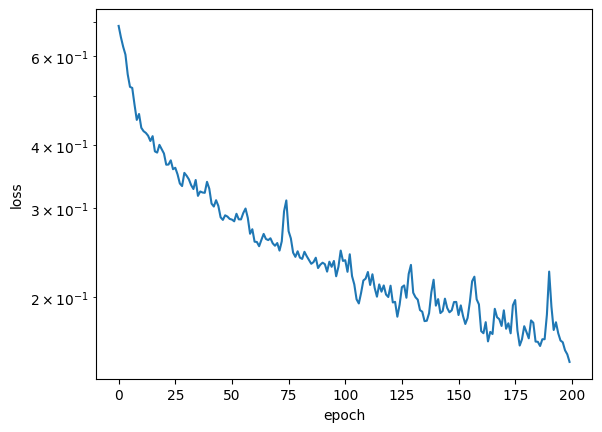

In [27]:
plt.plot(losses)
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")

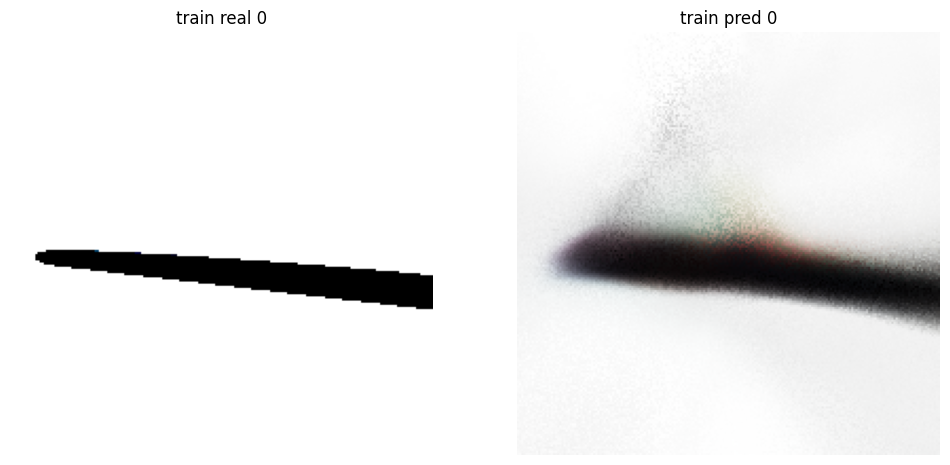

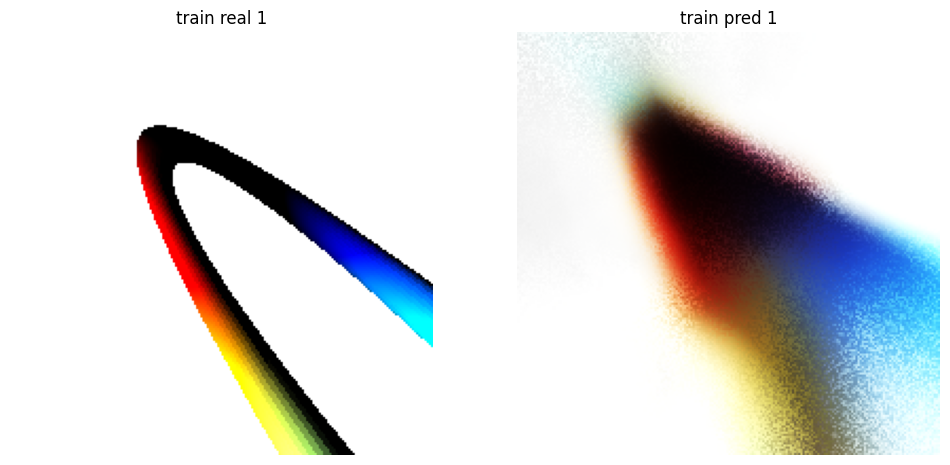

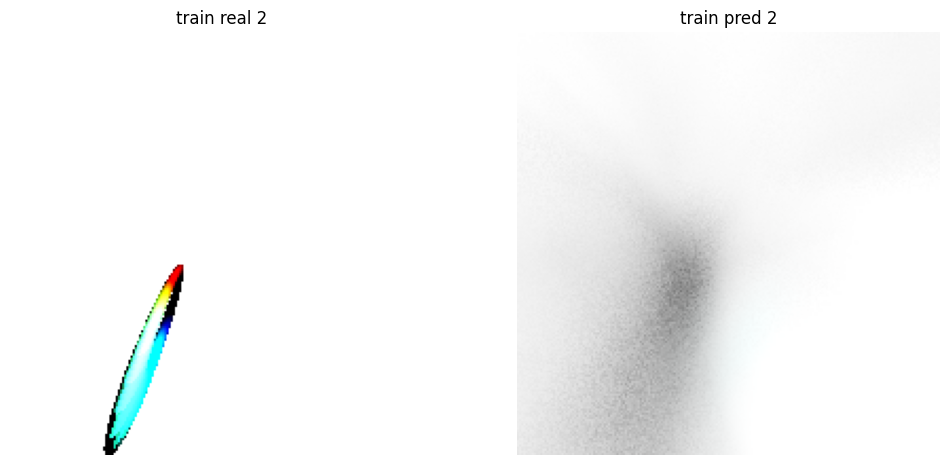

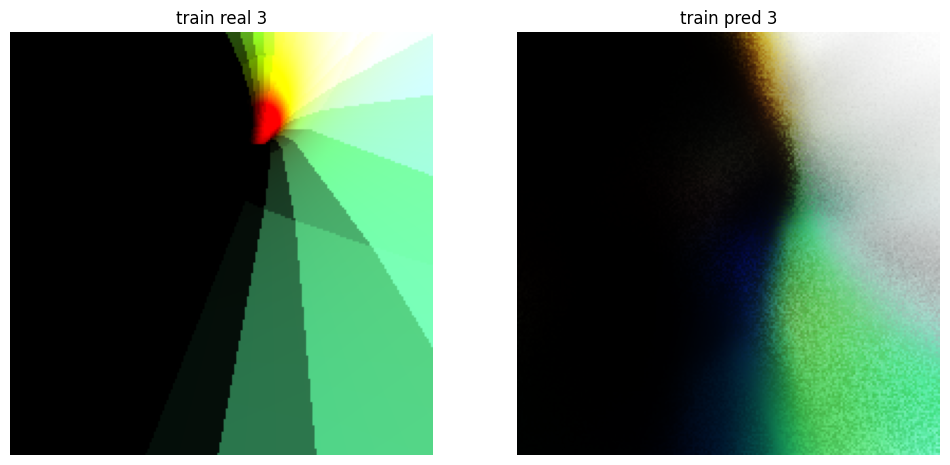

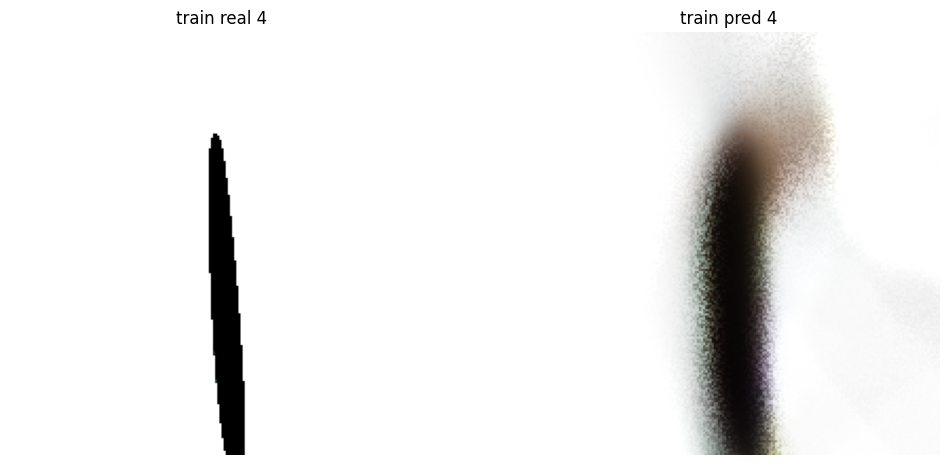

In [30]:
for i in range(min(num_train_views, 5)):
  camera_position, camera_rotation_angles, rendered_view = train_positions[i], train_angles[i], train_images[i]
  pred = render_from_nerf(nerf, camera_position/8, camera_rotation_angles, delta=1e-1, distance=32,
                image_height=image_height, image_width=image_width, view_plane_width=view_plane_width, mask=None, batch_chunks=2048)
  fig, axs = plt.subplots(1,2, figsize=(12, 6))
  for ax, title, im in zip(axs, [f"train real {i}", f"train pred {i}"], [rendered_view, pred.numpy().reshape(rendered_view.shape)]):
    ax.imshow(im)
    ax.set_title(title)
    ax.axis('off')
  plt.show()

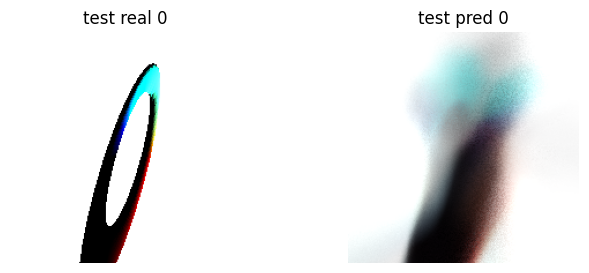

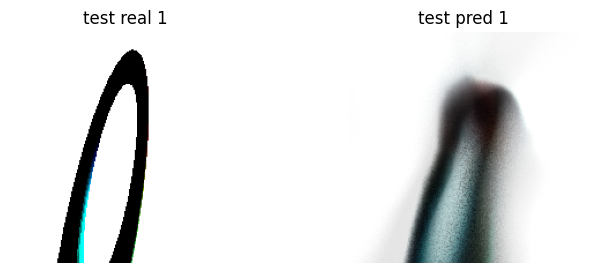

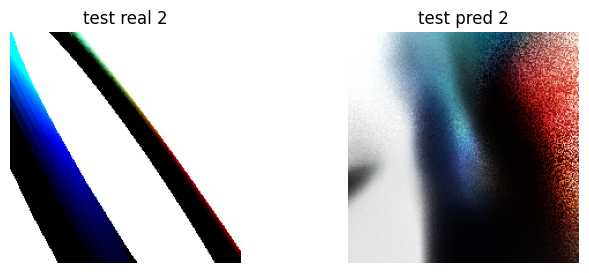

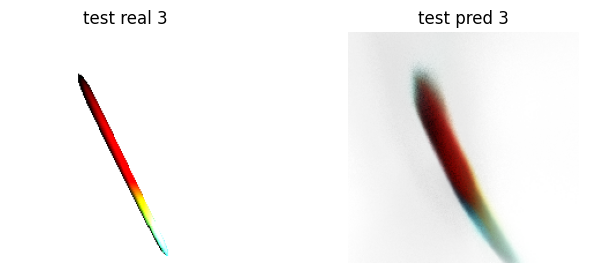

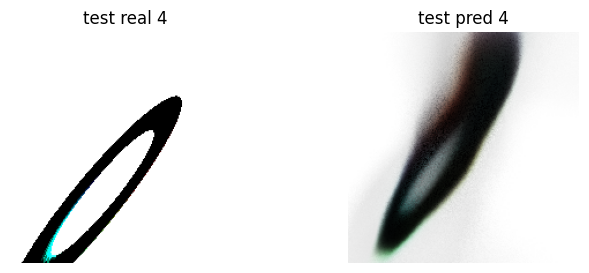

In [31]:
for i in range(min(num_test_views, 5)):
  camera_position, camera_rotation_angles, rendered_view = test_positions[i], test_angles[i], test_images[i]
  pred = render_from_nerf(nerf, camera_position/8, camera_rotation_angles, delta=1e-1, distance=32,
                image_height=image_height, image_width=image_width, view_plane_width=view_plane_width, mask=None, batch_chunks=2048)
  fig, axs = plt.subplots(1,2, figsize=(8, 3))
  for ax, title, im in zip(axs, [f"test real {i}", f"test pred {i}"], [rendered_view, pred.numpy().reshape(rendered_view.shape)]):
    ax.imshow(im)
    ax.set_title(title)
    ax.axis('off')
  plt.show()